## Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import r2_score 
import joblib


## Getting Data

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
val_df = pd.read_csv("data/val.csv")

In [3]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


## Splitting Data

In [4]:
X_train= train_df.drop(columns="price")
y_train=train_df.price.copy()

In [5]:
X_test= test_df.drop(columns="price")
y_test=test_df.price.copy()

X_val= val_df.drop(columns="price")
y_val=val_df.price.copy()

In [6]:
X_train.shape,y_train.shape

((640, 9), (640,))

## data preprocessing

In [7]:
date_time=["date_of_journey","dep_time","arrival_time"]
num_col = ["duration","total_stops"]
cat_col = [col for col in X_train.columns if (col not in date_time) and (col not in num_col)]

In [8]:
cat_col

['airline', 'source', 'destination', 'additional_info']

In [9]:
num_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])
cat_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month","week","day_of_week","day_of_month"], format="mixed")),
    ("scaler" ,StandardScaler())
])
time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour","minute"], format="mixed")),
    ("scaler" ,StandardScaler())
])


In [10]:
preprocessor=ColumnTransformer(transformers=[
    ("num",num_pipe,num_col),
    ("cat",cat_pipe,cat_col),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time", time_transformer,["dep_time","arrival_time"])
])

In [11]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

## Model Selection

In [12]:
data=pd.concat([train_df,val_df],axis=0)


In [13]:
X_data=data.drop(['price'],axis=1)
y_data=data['price']
X_data.shape,y_data.shape

((800, 9), (800,))

In [14]:
algorithms={
    "linear regression":LinearRegression(),
    "SVM": SVR(),
    "random forest": RandomForestRegressor(n_estimators=10),
    "xg Boost": XGBRegressor(n_estimators=10)
}

In [15]:
def plot_curves(sizes, mean_scores, std_scores,label ,ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )
    ax.fill_between(
        x=sizes,
        y1 = mean_scores - std_scores,
        y2 = mean_scores + std_scores,
        alpha=0.5
    )
    

In [16]:
def plot_learning_curve(name, algorithm):
    model=Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
         estimator=model,
         X=X_data,
         y=y_data,
         cv=3,
         scoring="r2",
         n_jobs=-1,
         random_state=42
      )
 
    mean_train_scores = np.mean(train_scores,axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores,axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"


    fig,ax = plt.subplots(figsize=(12,9))

    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train({train_score})",
        ax
    )

    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test({test_score})",
        ax
    )
    ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
    ax.legend(loc="lower right")
    plt.show()

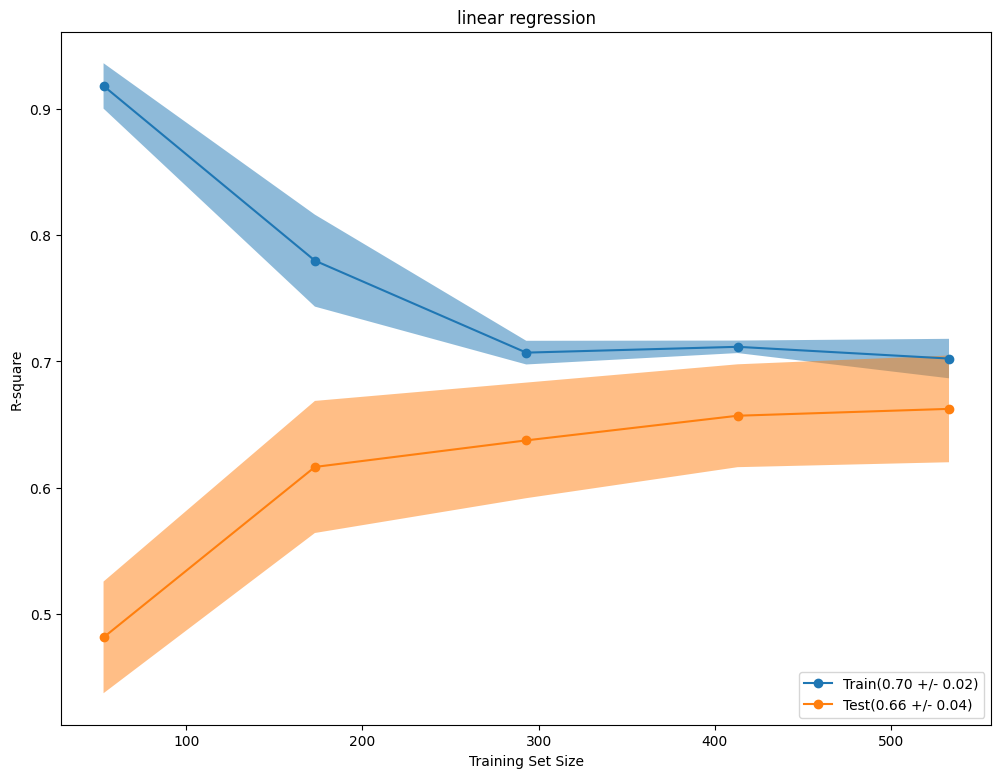

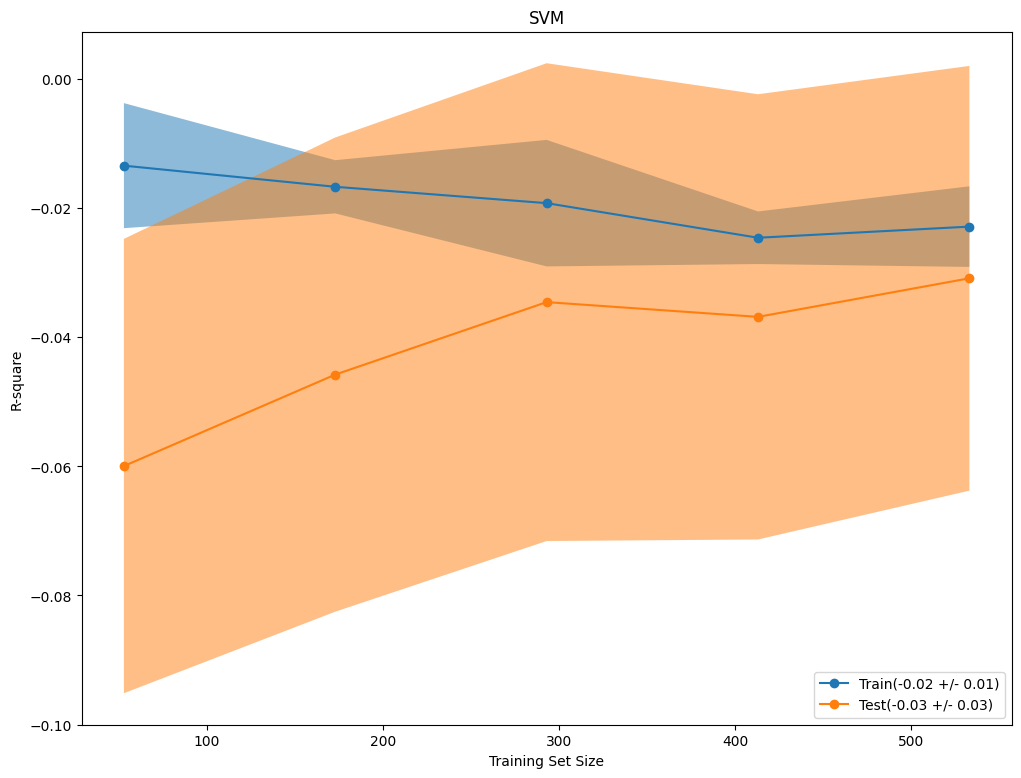

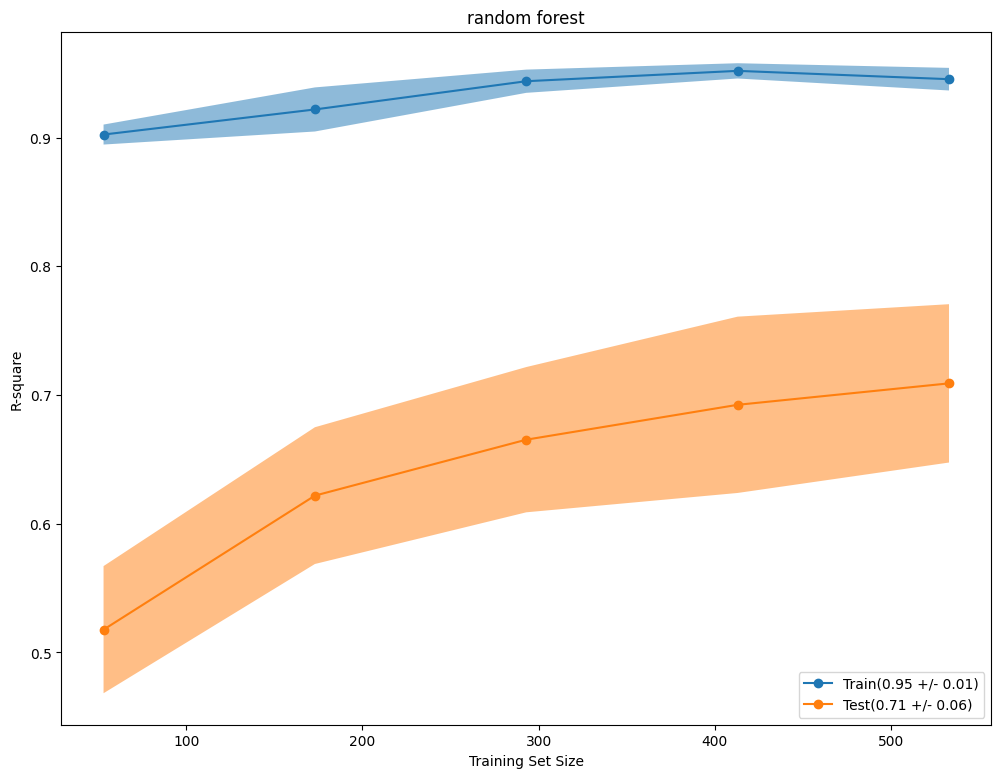

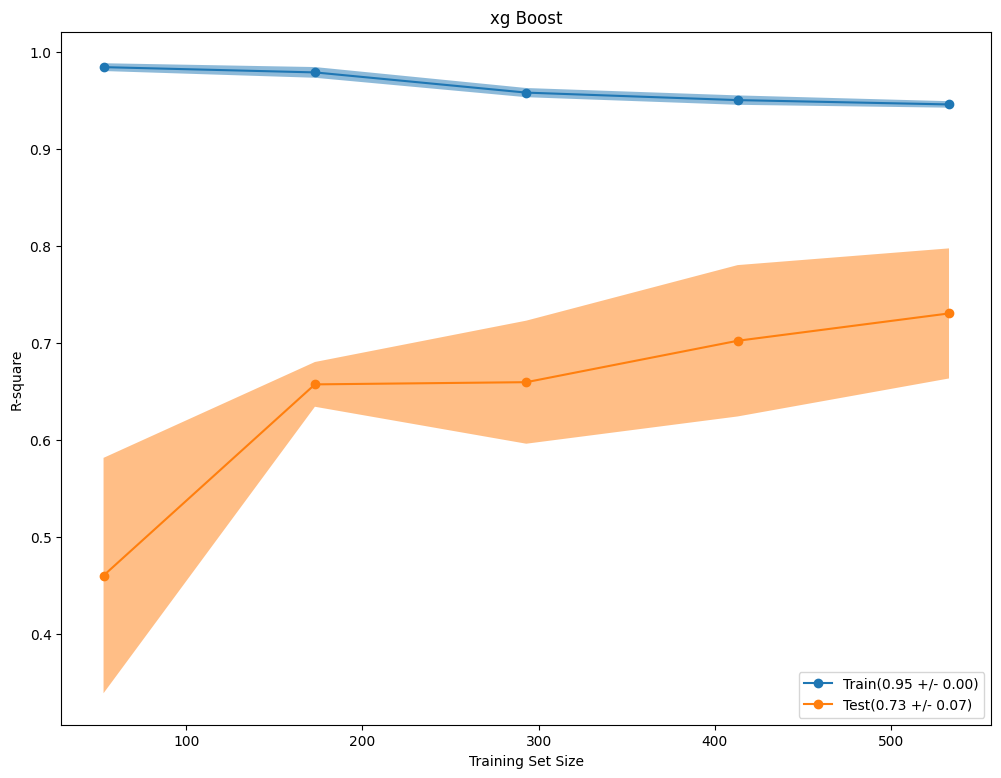

In [17]:
for name,alg in algorithms.items():
    plot_learning_curve(name,alg)

## Model Training

In [18]:
model= Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor())
])

In [19]:
model.fit(X_data,y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_week',
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor())])

## Model Evaluation

In [20]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y,y_pred)

In [21]:
evaluate_model(X_data,y_data)

0.9639930143374472

In [22]:
evaluate_model(X_test,y_test)

0.7048445649838357

## Saving Model

In [23]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [24]:
saved_model = joblib.load("model.joblib")

In [25]:
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_week',
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor())])